# Bivector Component Analysis (BCA): A Tutorial

**Agus Sudjianto, Arpit Narain and Sandi Setiawan**

---

This notebook demonstrates **Bivector Component Analysis (BCA)**, a geometric-algebraic extension of PCA that decomposes the lagged second-moment operator into:

1. A **symmetric component** (analyzed by PCA) — captures co-movement
2. An **antisymmetric component** (analyzed by BCA) — captures *oriented flow* (lead–lag, sector rotation)

**Key insight**: PCA is *time-direction agnostic* — it cannot tell which variables move first. BCA explicitly extracts this directional information.

We apply BCA to 11 U.S. sector ETFs and discover a growth-to-defensive rotation pattern that PCA cannot detect.

## 1. Setup and Imports

In [19]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Plot style
plt.rcParams.update({
    'figure.dpi': 120,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})
sns.set_style('whitegrid')

Using device: cuda


## 2. Theoretical Background

### The Problem with PCA on Time Series

Given a centered $d$-dimensional time series $(X_t)$, the lag-$\tau$ second-moment matrix is:

$$M_\tau = \mathbb{E}[X_t X_{t+\tau}^\top]$$

This matrix is **not symmetric** in general (for $\tau \geq 1$), because $\mathbb{E}[X_t[i] \, X_{t+\tau}[j]] \neq \mathbb{E}[X_t[j] \, X_{t+\tau}[i]]$.

### Symmetric–Antisymmetric Decomposition

Any matrix can be uniquely decomposed:

$$M_\tau = \underbrace{\frac{1}{2}(M_\tau + M_\tau^\top)}_{C_\tau \text{ (symmetric)}} + \underbrace{\frac{1}{2}(M_\tau - M_\tau^\top)}_{B_\tau \text{ (antisymmetric)}}$$

- **$C_\tau$**: What PCA analyzes. Symmetric $\Rightarrow$ *direction-blind*. It averages "$i$ leads $j$" with "$j$ leads $i$".
- **$B_\tau$**: What BCA analyzes. Antisymmetric ($B_\tau^\top = -B_\tau$) $\Rightarrow$ encodes *which variable leads which*.

### Geometric Algebra Connection

In geometric algebra, the geometric product of vectors decomposes as:

$$xy = \underbrace{x \cdot y}_{\text{inner product (symmetric)}} + \underbrace{x \wedge y}_{\text{outer product (antisymmetric)}}$$

The outer product $x \wedge y$ is a **bivector** — an oriented plane. The antisymmetric component $B_\tau$ is precisely this "bivector part" of the lagged second moment, encoding oriented planes of rotation in data space.

### BCA Eigendecomposition

A real antisymmetric matrix $B$ has a canonical form (Theorem):

$$Q^\top B Q = \text{blockdiag}\left( \begin{bmatrix} 0 & \omega_1 \\ -\omega_1 & 0 \end{bmatrix}, \begin{bmatrix} 0 & \omega_2 \\ -\omega_2 & 0 \end{bmatrix}, \ldots \right)$$

where $\omega_1 \geq \omega_2 \geq \cdots \geq 0$ are the **rotation strengths**. Each $2 \times 2$ block defines a **rotation plane** — a bivector component.

The eigenvalues come in purely imaginary conjugate pairs: $\pm i\omega_k$. Each pair's eigenvectors define the rotation plane, with:
- **Real part** $u_k$ = "leading" direction
- **Imaginary part** $w_k$ = "lagging" direction

## 3. Data: U.S. Sector ETFs

We analyze daily returns of 11 SPDR sector ETFs over Nov 2020 – Oct 2025.

In [20]:
# Define sector ETFs
tickers = ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
sector_names = {
    'XLK': 'Technology', 'XLF': 'Financials', 'XLE': 'Energy',
    'XLV': 'Healthcare', 'XLI': 'Industrials', 'XLP': 'Consumer Staples',
    'XLY': 'Consumer Discr.', 'XLU': 'Utilities', 'XLB': 'Materials',
    'XLRE': 'Real Estate', 'XLC': 'Communication'
}

# Download data
print('Downloading sector ETF data...')
data = yf.download(tickers, start='2020-11-04', end='2025-10-31', auto_adjust=True)['Close']
data = data[tickers]  # ensure consistent order
print(f'Downloaded {len(data)} trading days, {len(tickers)} sectors')
data.tail()

[*********************100%***********************]  11 of 11 completed

Downloaded 1253 trading days, 11 sectors


Ticker,XLK,XLF,XLE,XLV,XLI,XLP,XLY,XLU,XLB,XLRE,XLC
Date,,,,,,,,,,,
2025-10-24,146.567688,52.925026,43.662804,145.410782,154.381241,78.460526,118.594971,45.355206,44.276443,42.188923,115.177132
2025-10-27,149.273590,53.144260,43.766914,145.749344,155.258240,78.589500,120.301590,45.479279,44.256546,42.277950,116.781937
2025-10-28,150.751343,52.805443,43.310802,144.833237,154.152023,77.805786,120.331528,44.729893,44.316235,41.338219,116.203804
2025-10-29,151.834702,51.908577,43.633057,143.369476,154.550659,75.970512,119.338493,44.715004,43.445728,40.210545,115.914742
2025-10-30,149.967545,52.048088,43.375252,143.688126,154.162003,75.891144,116.643837,44.526417,42.863735,40.438057,113.951096


[*********************100%***********************]  11 of 11 completed

Downloaded 1253 trading days, 11 sectors


Ticker,XLK,XLF,XLE,XLV,XLI,XLP,XLY,XLU,XLB,XLRE,XLC
Date,,,,,,,,,,,
2025-10-24,146.567688,52.925026,43.662804,145.410782,154.381241,78.460526,118.594971,45.355206,44.276443,42.188923,115.177132
2025-10-27,149.273590,53.144260,43.766914,145.749344,155.258240,78.589500,120.301590,45.479279,44.256546,42.277950,116.781937
2025-10-28,150.751343,52.805443,43.310802,144.833237,154.152023,77.805786,120.331528,44.729893,44.316235,41.338219,116.203804
2025-10-29,151.834702,51.908577,43.633057,143.369476,154.550659,75.970512,119.338493,44.715004,43.445728,40.210545,115.914742
2025-10-30,149.967545,52.048088,43.375252,143.688126,154.162003,75.891144,116.643837,44.526417,42.863735,40.438057,113.951096


In [21]:
# Compute log returns, center, and standardize
log_returns = np.log(data / data.shift(1)).dropna()

# Center and standardize each series
returns_centered = log_returns - log_returns.mean()
returns_std = returns_centered / returns_centered.std()

print(f'Return series: {returns_std.shape[0]} observations x {returns_std.shape[1]} sectors')
print(f'\nMean (should be ~0):\n{returns_std.mean().round(6)}')
print(f'\nStd (should be ~1):\n{returns_std.std().round(6)}')

Return series: 1252 observations x 11 sectors

Mean (should be ~0):
Ticker
XLK     0.0
XLF     0.0
XLE     0.0
XLV    -0.0
XLI    -0.0
XLP     0.0
XLY     0.0
XLU     0.0
XLB     0.0
XLRE    0.0
XLC     0.0
dtype: float64

Std (should be ~1):
Ticker
XLK     1.0
XLF     1.0
XLE     1.0
XLV     1.0
XLI     1.0
XLP     1.0
XLY     1.0
XLU     1.0
XLB     1.0
XLRE    1.0
XLC     1.0
dtype: float64


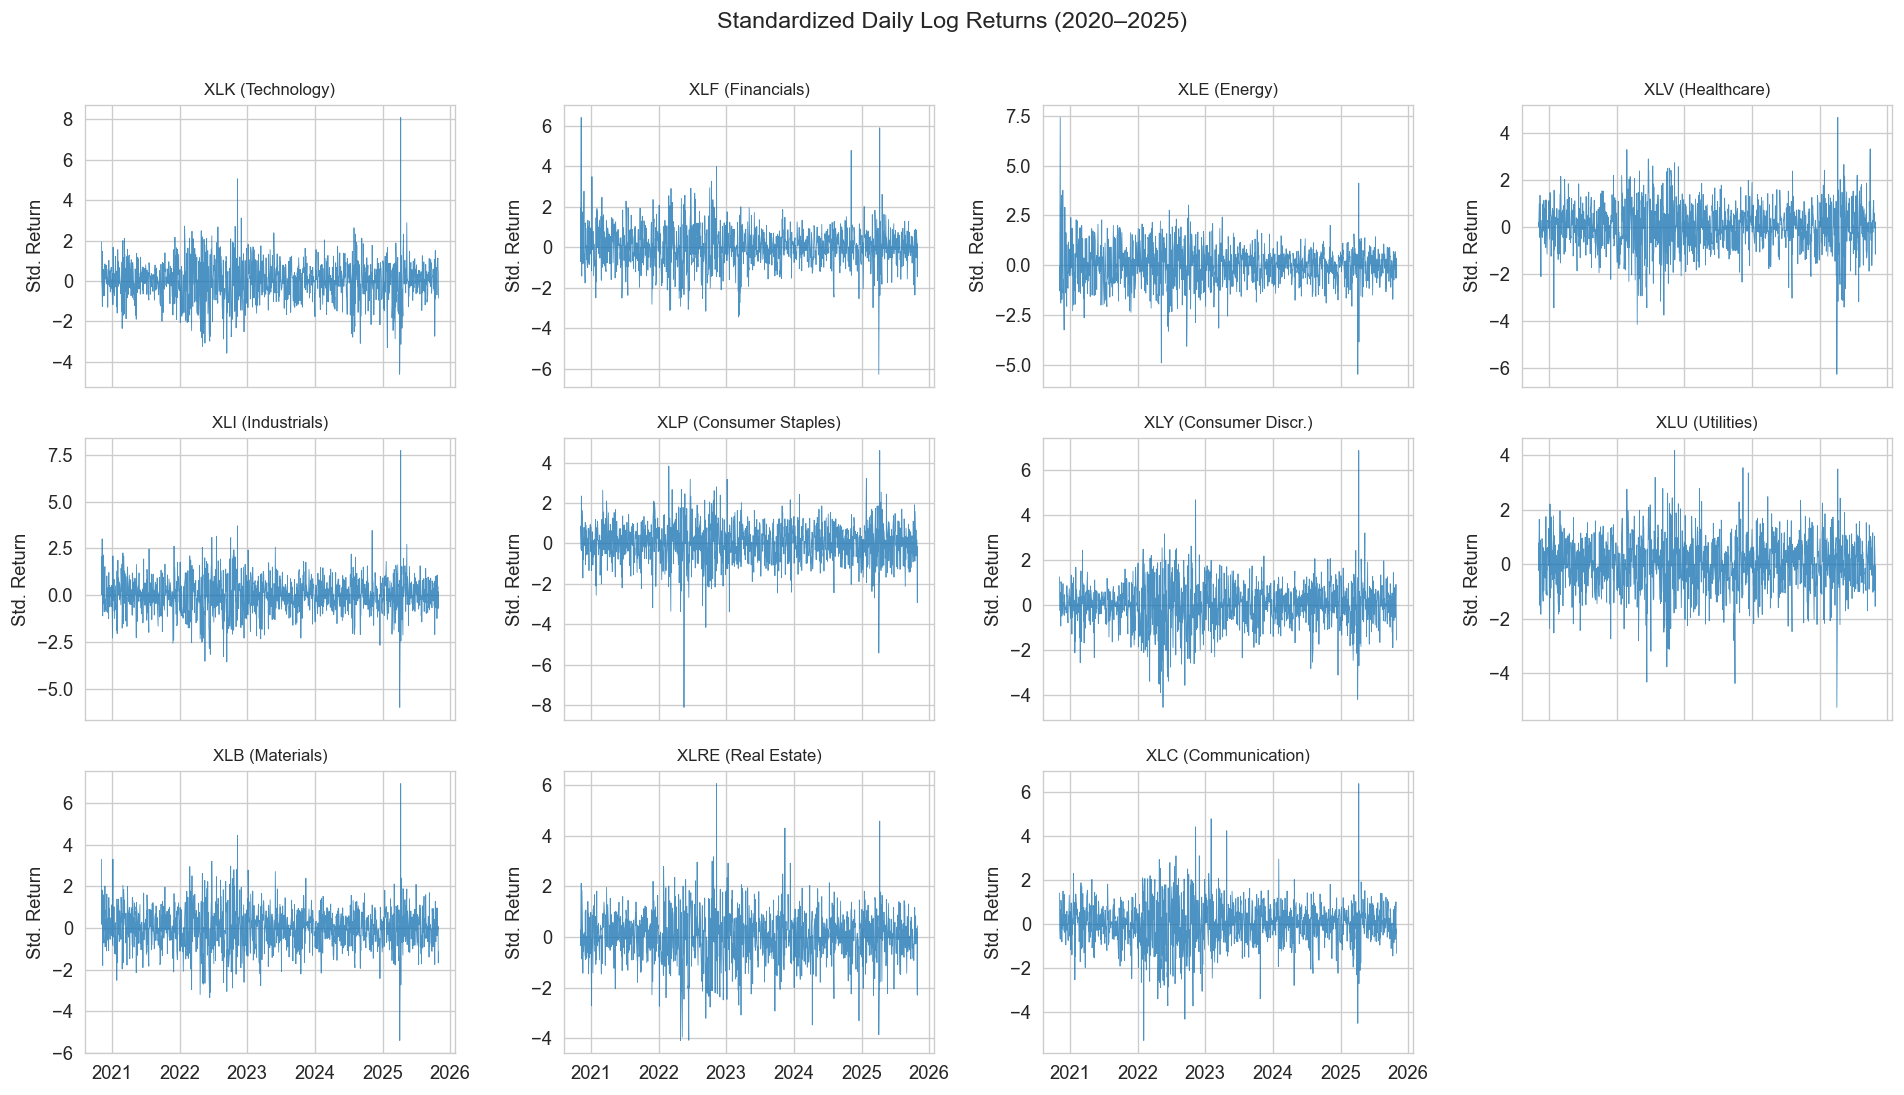

In [22]:
# Visualize the return series
fig, axes = plt.subplots(3, 4, figsize=(16, 9), sharex=True)
axes = axes.flatten()
for i, ticker in enumerate(tickers):
    axes[i].plot(returns_std.index, returns_std[ticker], linewidth=0.5, alpha=0.8)
    axes[i].set_title(f'{ticker} ({sector_names[ticker]})', fontsize=10)
    axes[i].set_ylabel('Std. Return')
axes[-1].set_visible(False)  # hide unused subplot
fig.suptitle('Standardized Daily Log Returns (2020–2025)', fontsize=14, y=1.01)
plt.tight_layout()
fig.savefig('fig_returns.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Standard PCA (Symmetric Component)

First, we perform standard PCA on the contemporaneous covariance matrix $C_0 = \mathbb{E}[X_t X_t^\top]$.

PCA captures **co-movement** but is *blind to temporal direction*.

In [23]:
# Convert to torch tensor
X = torch.tensor(returns_std.values, dtype=torch.float64, device=device)
T, d = X.shape
print(f'Data tensor: {T} x {d}')

# Contemporaneous covariance (symmetric by construction)
C0 = (X.T @ X) / T
print(f'\nC0 is symmetric: {torch.allclose(C0, C0.T)}')

# PCA via eigendecomposition
eigenvalues_pca, eigenvectors_pca = torch.linalg.eigh(C0)
# Sort descending
idx = torch.argsort(eigenvalues_pca, descending=True)
eigenvalues_pca = eigenvalues_pca[idx]
eigenvectors_pca = eigenvectors_pca[:, idx]

# Explained variance
explained_var = eigenvalues_pca / eigenvalues_pca.sum() * 100
cumulative_var = torch.cumsum(explained_var, dim=0)

print('\nPCA Explained Variance:')
print('-' * 40)
for i in range(min(5, d)):
    print(f'  PC{i+1}: {explained_var[i].item():.1f}%  (Cumulative: {cumulative_var[i].item():.1f}%)')

Data tensor: 1252 x 11

C0 is symmetric: True

PCA Explained Variance:
----------------------------------------
  PC1: 60.1%  (Cumulative: 60.1%)
  PC2: 11.1%  (Cumulative: 71.2%)
  PC3: 9.1%  (Cumulative: 80.3%)
  PC4: 4.3%  (Cumulative: 84.6%)
  PC5: 3.2%  (Cumulative: 87.8%)



PCA Explained Variance:
----------------------------------------
  PC1: 60.1%  (Cumulative: 60.1%)
  PC2: 11.1%  (Cumulative: 71.2%)
  PC3: 9.1%  (Cumulative: 80.3%)
  PC4: 4.3%  (Cumulative: 84.6%)
  PC5: 3.2%  (Cumulative: 87.8%)


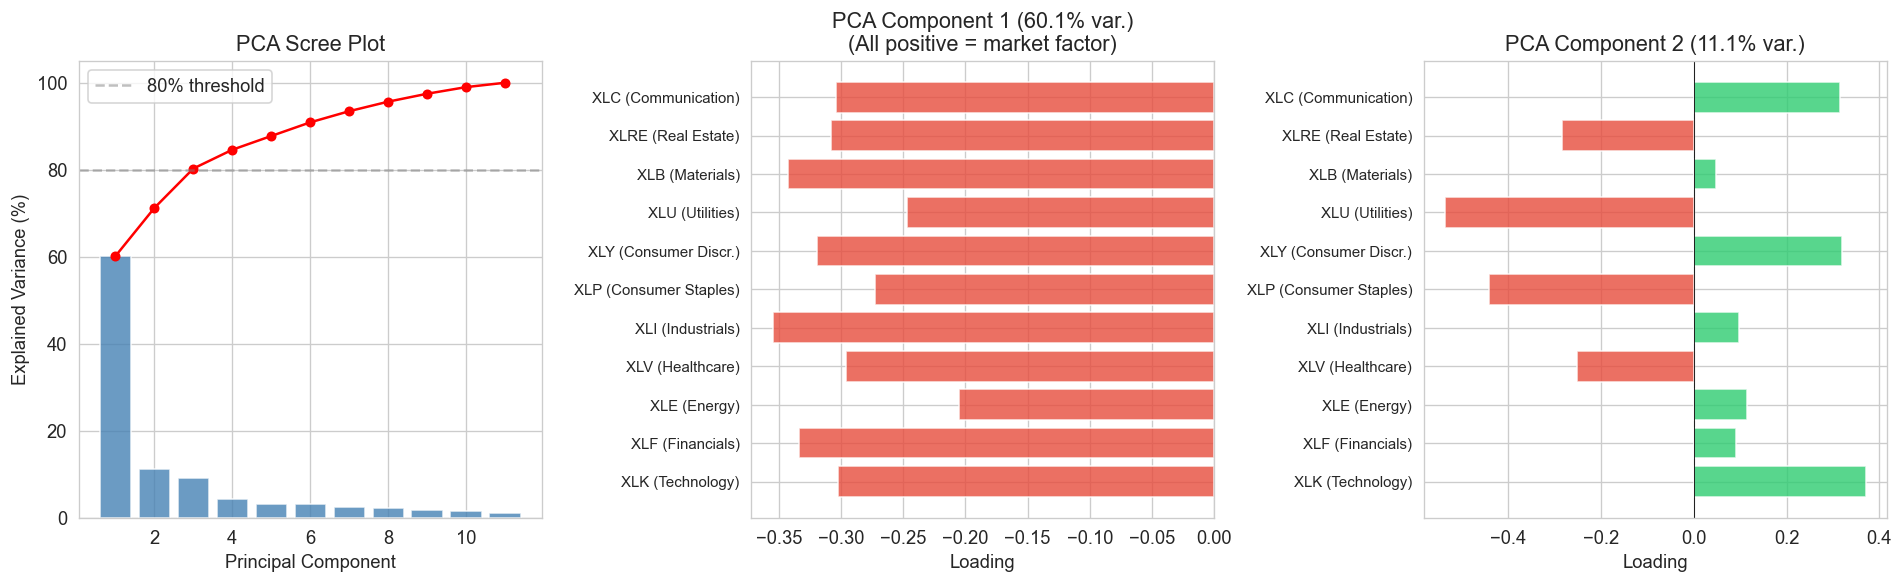


Key observation: PC1 has uniformly positive loadings (market factor).
PCA tells us sectors co-move, but NOT which sectors move FIRST.


In [24]:
# Visualize PCA results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scree plot
axes[0].bar(range(1, d+1), explained_var.cpu().numpy(), color='steelblue', alpha=0.8)
axes[0].plot(range(1, d+1), cumulative_var.cpu().numpy(), 'ro-', markersize=5)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('PCA Scree Plot')
axes[0].axhline(y=80, color='gray', linestyle='--', alpha=0.5, label='80% threshold')
axes[0].legend()

# PC1 loadings — note the uniform sign
pc1 = eigenvectors_pca[:, 0].cpu().numpy()
colors = ['#2ecc71' if v >= 0 else '#e74c3c' for v in pc1]
axes[1].barh(range(d), pc1, color=colors, alpha=0.8)
axes[1].set_yticks(range(d))
axes[1].set_yticklabels([f'{t} ({sector_names[t]})' for t in tickers], fontsize=9)
axes[1].set_xlabel('Loading')
axes[1].set_title(f'PCA Component 1 ({explained_var[0].item():.1f}% var.)\n(All positive = market factor)')
axes[1].axvline(x=0, color='black', linewidth=0.5)

# PC2 loadings
pc2 = eigenvectors_pca[:, 1].cpu().numpy()
colors2 = ['#2ecc71' if v >= 0 else '#e74c3c' for v in pc2]
axes[2].barh(range(d), pc2, color=colors2, alpha=0.8)
axes[2].set_yticks(range(d))
axes[2].set_yticklabels([f'{t} ({sector_names[t]})' for t in tickers], fontsize=9)
axes[2].set_xlabel('Loading')
axes[2].set_title(f'PCA Component 2 ({explained_var[1].item():.1f}% var.)')
axes[2].axvline(x=0, color='black', linewidth=0.5)

plt.tight_layout()
fig.savefig('fig_pca_results.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKey observation: PC1 has uniformly positive loadings (market factor).')
print('PCA tells us sectors co-move, but NOT which sectors move FIRST.')

## 5. Bivector Component Analysis (BCA)

### Step 1: Compute the Lag-1 Second Moment Matrix

$$M_1 = \frac{1}{T-1} \sum_{t=1}^{T-1} X_t X_{t+1}^\top$$

This matrix is **not symmetric** — $M_1[i,j]$ measures how asset $i$ at time $t$ correlates with asset $j$ at time $t+1$.

In [25]:
# Compute lag-1 second moment matrix
tau = 1
X_t = X[:-tau]      # X_t: shape (T-tau, d)
X_t1 = X[tau:]      # X_{t+tau}: shape (T-tau, d)
n = X_t.shape[0]

M_tau = (X_t.T @ X_t1) / n  # lag-tau second moment

print(f'M_tau shape: {M_tau.shape}')
print(f'M_tau is symmetric: {torch.allclose(M_tau, M_tau.T, atol=1e-10)}')
print(f'Max asymmetry |M - M^T|: {(M_tau - M_tau.T).abs().max().item():.6f}')

M_tau shape: torch.Size([11, 11])
M_tau is symmetric: False
Max asymmetry |M - M^T|: 0.099242


### Step 2: Decompose into Symmetric and Antisymmetric Parts

$$C_1 = \frac{1}{2}(M_1 + M_1^\top), \qquad B_1 = \frac{1}{2}(M_1 - M_1^\top)$$

In [26]:
# Symmetric-antisymmetric decomposition
C_tau = 0.5 * (M_tau + M_tau.T)   # symmetric part
B_tau = 0.5 * (M_tau - M_tau.T)   # antisymmetric part

# Verify properties
print('Verification:')
print(f'  C_tau is symmetric: {torch.allclose(C_tau, C_tau.T, atol=1e-14)}')
print(f'  B_tau is antisymmetric: {torch.allclose(B_tau, -B_tau.T, atol=1e-14)}')
print(f'  C_tau + B_tau = M_tau: {torch.allclose(C_tau + B_tau, M_tau, atol=1e-14)}')

# Frobenius orthogonality
frob_inner = torch.trace(C_tau.T @ B_tau)
print(f'  <C, B>_F = {frob_inner.item():.2e} (should be ~0)')

# Relative magnitudes
frob_C = torch.norm(C_tau, 'fro').item()
frob_B = torch.norm(B_tau, 'fro').item()
frob_M = torch.norm(M_tau, 'fro').item()
print(f'\nFrobenius norms:')
print(f'  ||M_tau||_F = {frob_M:.4f}')
print(f'  ||C_tau||_F = {frob_C:.4f} ({frob_C**2/frob_M**2*100:.1f}% of energy)')
print(f'  ||B_tau||_F = {frob_B:.4f} ({frob_B**2/frob_M**2*100:.1f}% of energy)')
print(f'  ||C||^2 + ||B||^2 = {frob_C**2 + frob_B**2:.4f} vs ||M||^2 = {frob_M**2:.4f}')

Verification:
  C_tau is symmetric: True
  B_tau is antisymmetric: True
  C_tau + B_tau = M_tau: True
  <C, B>_F = -8.67e-19 (should be ~0)

Frobenius norms:
  ||M_tau||_F = 0.2751
  ||C_tau||_F = 0.1779 (41.8% of energy)
  ||B_tau||_F = 0.2098 (58.2% of energy)
  ||C||^2 + ||B||^2 = 0.0757 vs ||M||^2 = 0.0757


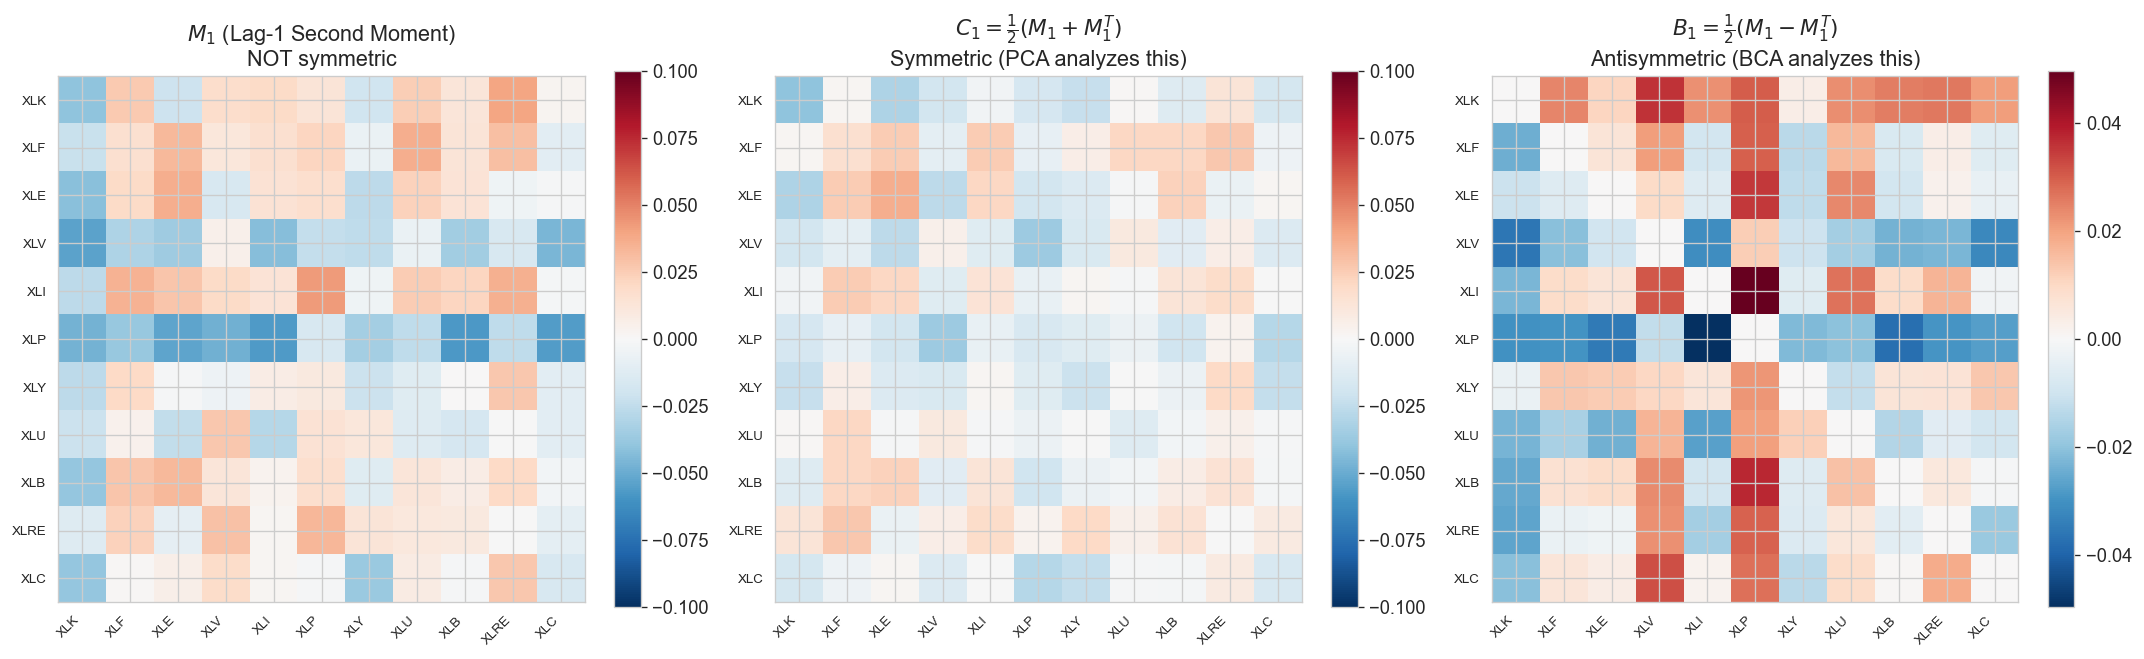

Note: B_1 has zero diagonal and B[i,j] = -B[j,i].
If B[i,j] > 0, asset i tends to LEAD asset j at lag 1.


In [27]:
# Visualize all three matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
labels = [f'{t}' for t in tickers]

# M_tau (full lagged moment)
vmax = max(M_tau.abs().max().item(), 0.1)
im0 = axes[0].imshow(M_tau.cpu().numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='equal')
axes[0].set_xticks(range(d)); axes[0].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
axes[0].set_yticks(range(d)); axes[0].set_yticklabels(labels, fontsize=8)
axes[0].set_title('$M_1$ (Lag-1 Second Moment)\nNOT symmetric')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# C_tau (symmetric part)
im1 = axes[1].imshow(C_tau.cpu().numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='equal')
axes[1].set_xticks(range(d)); axes[1].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
axes[1].set_yticks(range(d)); axes[1].set_yticklabels(labels, fontsize=8)
axes[1].set_title('$C_1 = \\frac{1}{2}(M_1 + M_1^T)$\nSymmetric (PCA analyzes this)')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# B_tau (antisymmetric part)
vmax_B = B_tau.abs().max().item()
im2 = axes[2].imshow(B_tau.cpu().numpy(), cmap='RdBu_r', vmin=-vmax_B, vmax=vmax_B, aspect='equal')
axes[2].set_xticks(range(d)); axes[2].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
axes[2].set_yticks(range(d)); axes[2].set_yticklabels(labels, fontsize=8)
axes[2].set_title('$B_1 = \\frac{1}{2}(M_1 - M_1^T)$\nAntisymmetric (BCA analyzes this)')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
fig.savefig('fig_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print('Note: B_1 has zero diagonal and B[i,j] = -B[j,i].')
print('If B[i,j] > 0, asset i tends to LEAD asset j at lag 1.')

### Step 3: BCA Eigendecomposition

We compute the eigenvalues of $B_1$. Since $B_1$ is real antisymmetric, its eigenvalues are purely imaginary: $\{0, \pm i\omega_1, \pm i\omega_2, \ldots\}$.

The **rotation strengths** $\omega_k$ measure the magnitude of each oriented rotation plane.

In [28]:
def bca_decomposition(B, n_components=None):
    """
    Bivector Component Analysis: eigendecomposition of an antisymmetric matrix.
    
    Parameters
    ----------
    B : torch.Tensor, shape (d, d)
        Antisymmetric matrix (B^T = -B)
    n_components : int, optional
        Number of bivector components to return (default: all)
    
    Returns
    -------
    rotation_strengths : array of shape (K,)
        Rotation strengths omega_k, sorted descending
    real_basis : array of shape (K, d)
        Real (leading) basis vectors u_k
    imag_basis : array of shape (K, d)
        Imaginary (lagging) basis vectors w_k
    """
    d = B.shape[0]
    
    # Eigendecomposition (complex)
    eigenvalues, eigenvectors = torch.linalg.eig(B.to(torch.float64))
    
    # Extract imaginary parts of eigenvalues
    imag_parts = eigenvalues.imag
    
    # Find positive imaginary eigenvalues (one from each conjugate pair)
    pos_mask = imag_parts > 1e-10
    pos_indices = torch.where(pos_mask)[0]
    
    # Sort by magnitude (descending)
    omega_vals = imag_parts[pos_indices]
    sort_idx = torch.argsort(omega_vals, descending=True)
    pos_indices = pos_indices[sort_idx]
    
    K = len(pos_indices) if n_components is None else min(n_components, len(pos_indices))
    
    rotation_strengths = []
    real_basis = []
    imag_basis = []
    
    for k in range(K):
        idx = pos_indices[k]
        omega_k = imag_parts[idx].item()
        v_k = eigenvectors[:, idx]  # complex eigenvector
        
        # Extract real and imaginary parts
        u_k = v_k.real.to(torch.float64)
        w_k = v_k.imag.to(torch.float64)
        
        # Orthonormalize
        u_k = u_k / torch.norm(u_k)
        w_k = w_k - torch.dot(w_k, u_k) * u_k
        w_k = w_k / torch.norm(w_k)
        
        rotation_strengths.append(omega_k)
        real_basis.append(u_k.cpu().numpy())
        imag_basis.append(w_k.cpu().numpy())
    
    return (
        np.array(rotation_strengths),
        np.array(real_basis),
        np.array(imag_basis)
    )

# Run BCA
rotation_strengths, real_basis, imag_basis = bca_decomposition(B_tau)

print('BCA Rotation Strengths:')
print('-' * 40)
for k, omega in enumerate(rotation_strengths):
    print(f'  Bivector Component {k+1}: omega = {omega:.4f}')
print(f'\nDominant rotation strength: omega_1 = {rotation_strengths[0]:.4f}')

BCA Rotation Strengths:
----------------------------------------
  Bivector Component 1: omega = 0.1428
  Bivector Component 2: omega = 0.0324
  Bivector Component 3: omega = 0.0213
  Bivector Component 4: omega = 0.0104
  Bivector Component 5: omega = 0.0048

Dominant rotation strength: omega_1 = 0.1428


### Step 4: Interpreting the First Bivector Component

The first bivector component defines a **rotation plane** with:
- **Real basis** $u_1$: the "leading" direction (assets that move first)
- **Imaginary basis** $w_1$: the "lagging" direction (assets that follow)

For each asset, we compute:
- **Magnitude** = $\sqrt{u_k[i]^2 + w_k[i]^2}$ (overall participation in the rotation)
- **Phase** = $\text{atan2}(w_k[i], u_k[i])$ (temporal position in the rotation cycle)

In [29]:
# Compute loadings, magnitudes, and phases for Component 1
u1 = real_basis[0]   # leading direction
w1 = imag_basis[0]   # lagging direction

# Sign convention: eigenvectors are determined up to a global sign.
# We choose the sign so that growth sectors (XLK) have positive real loadings,
# matching the interpretation: positive real = leading.
xlk_idx = tickers.index('XLK')
if u1[xlk_idx] < 0:
    u1 = -u1
    w1 = -w1

magnitudes = np.sqrt(u1**2 + w1**2)
phases_rad = np.arctan2(w1, u1)
phases_deg = np.degrees(phases_rad)

# Create results table
results = pd.DataFrame({
    'Sector': [sector_names[t] for t in tickers],
    'Real (Leading)': u1,
    'Imag (Lagging)': w1,
    'Magnitude': magnitudes,
    'Phase (deg)': phases_deg
}, index=tickers)

# Sort by magnitude
results_sorted = results.sort_values('Magnitude', ascending=False)

print('Bivector Component 1: Asset Loadings')
print('=' * 72)
print(results_sorted.to_string(float_format='{:.3f}'.format))
print(f'\nRotation strength: omega_1 = {rotation_strengths[0]:.4f}')

Bivector Component 1: Asset Loadings
                Sector  Real (Leading)  Imag (Lagging)  Magnitude  Phase (deg)
XLP   Consumer Staples          -0.677           0.000      0.677      180.000
XLK         Technology           0.401           0.334      0.522       39.746
XLV         Healthcare          -0.485           0.123      0.501      165.721
XLI        Industrials           0.100           0.490      0.501       78.475
XLB          Materials          -0.009           0.383      0.383       91.339
XLRE       Real Estate          -0.170           0.322      0.364      117.797
XLC      Communication           0.051           0.351      0.355       81.798
XLU          Utilities          -0.281           0.204      0.348      143.983
XLF         Financials          -0.074           0.338      0.346      102.374
XLE             Energy          -0.061           0.290      0.297      101.825
XLY    Consumer Discr.           0.126           0.137      0.187       47.427

Rotation stren

## 6. Visualization of BCA Results

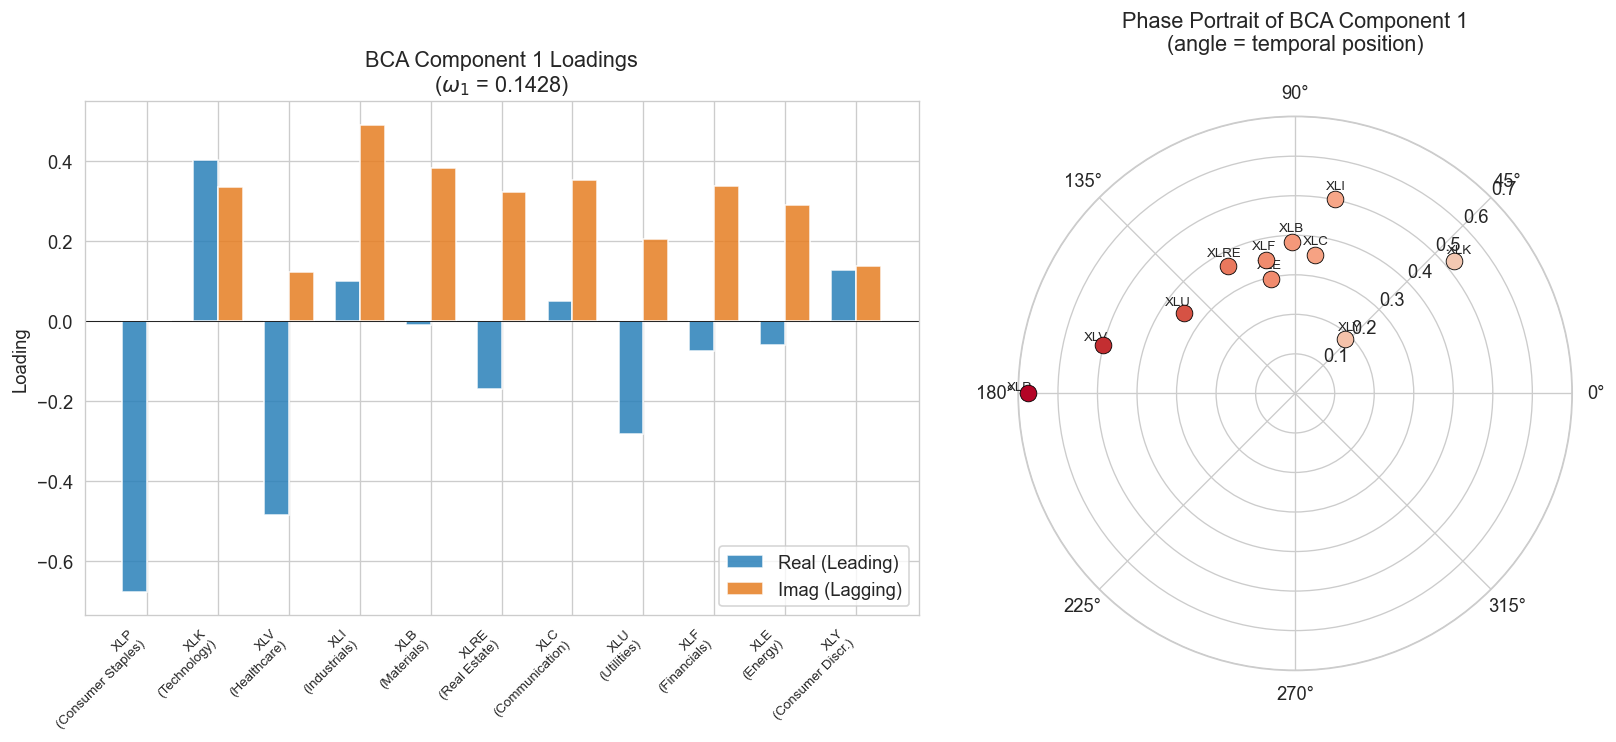

Interpretation:
  - Assets with large positive REAL loadings = LEADING sectors
  - Assets with large negative REAL loadings = LAGGING sectors (move in opposition)
  - IMAGINARY loadings capture the intermediate phase of the rotation


In [30]:
# --- Figure 1: BCA Loadings (Real vs Imaginary) ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart: Real (leading) and Imaginary (lagging) loadings side by side
x_pos = np.arange(d)
width = 0.35
sort_idx = np.argsort(-magnitudes)
sorted_tickers = [tickers[i] for i in sort_idx]
sorted_labels = [f'{tickers[i]}\n({sector_names[tickers[i]]})' for i in sort_idx]

bars1 = axes[0].bar(x_pos - width/2, u1[sort_idx], width, label='Real (Leading)', 
                     color='#2980b9', alpha=0.85)
bars2 = axes[0].bar(x_pos + width/2, w1[sort_idx], width, label='Imag (Lagging)', 
                     color='#e67e22', alpha=0.85)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(sorted_labels, fontsize=8, rotation=45, ha='right')
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_ylabel('Loading')
axes[0].set_title(f'BCA Component 1 Loadings\n($\\omega_1$ = {rotation_strengths[0]:.4f})')
axes[0].legend(loc='lower right')

# Polar/phase plot
ax_polar = fig.add_axes(axes[1].get_position(), polar=True)
axes[1].set_visible(False)

# Color by phase
norm = Normalize(vmin=-180, vmax=180)
cmap = cm.coolwarm

for i, ticker in enumerate(tickers):
    color = cmap(norm(phases_deg[i]))
    ax_polar.scatter(phases_rad[i], magnitudes[i], s=100, c=[color], 
                     edgecolors='black', linewidth=0.5, zorder=5)
    # Label with slight offset
    offset = 0.02
    ax_polar.annotate(ticker, (phases_rad[i], magnitudes[i] + offset), 
                      fontsize=8, ha='center', va='bottom')

ax_polar.set_title('Phase Portrait of BCA Component 1\n(angle = temporal position)', pad=20)
ax_polar.set_rlabel_position(45)

plt.tight_layout()
fig.savefig('fig_bca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

print('Interpretation:')
print('  - Assets with large positive REAL loadings = LEADING sectors')
print('  - Assets with large negative REAL loadings = LAGGING sectors (move in opposition)')
print('  - IMAGINARY loadings capture the intermediate phase of the rotation')

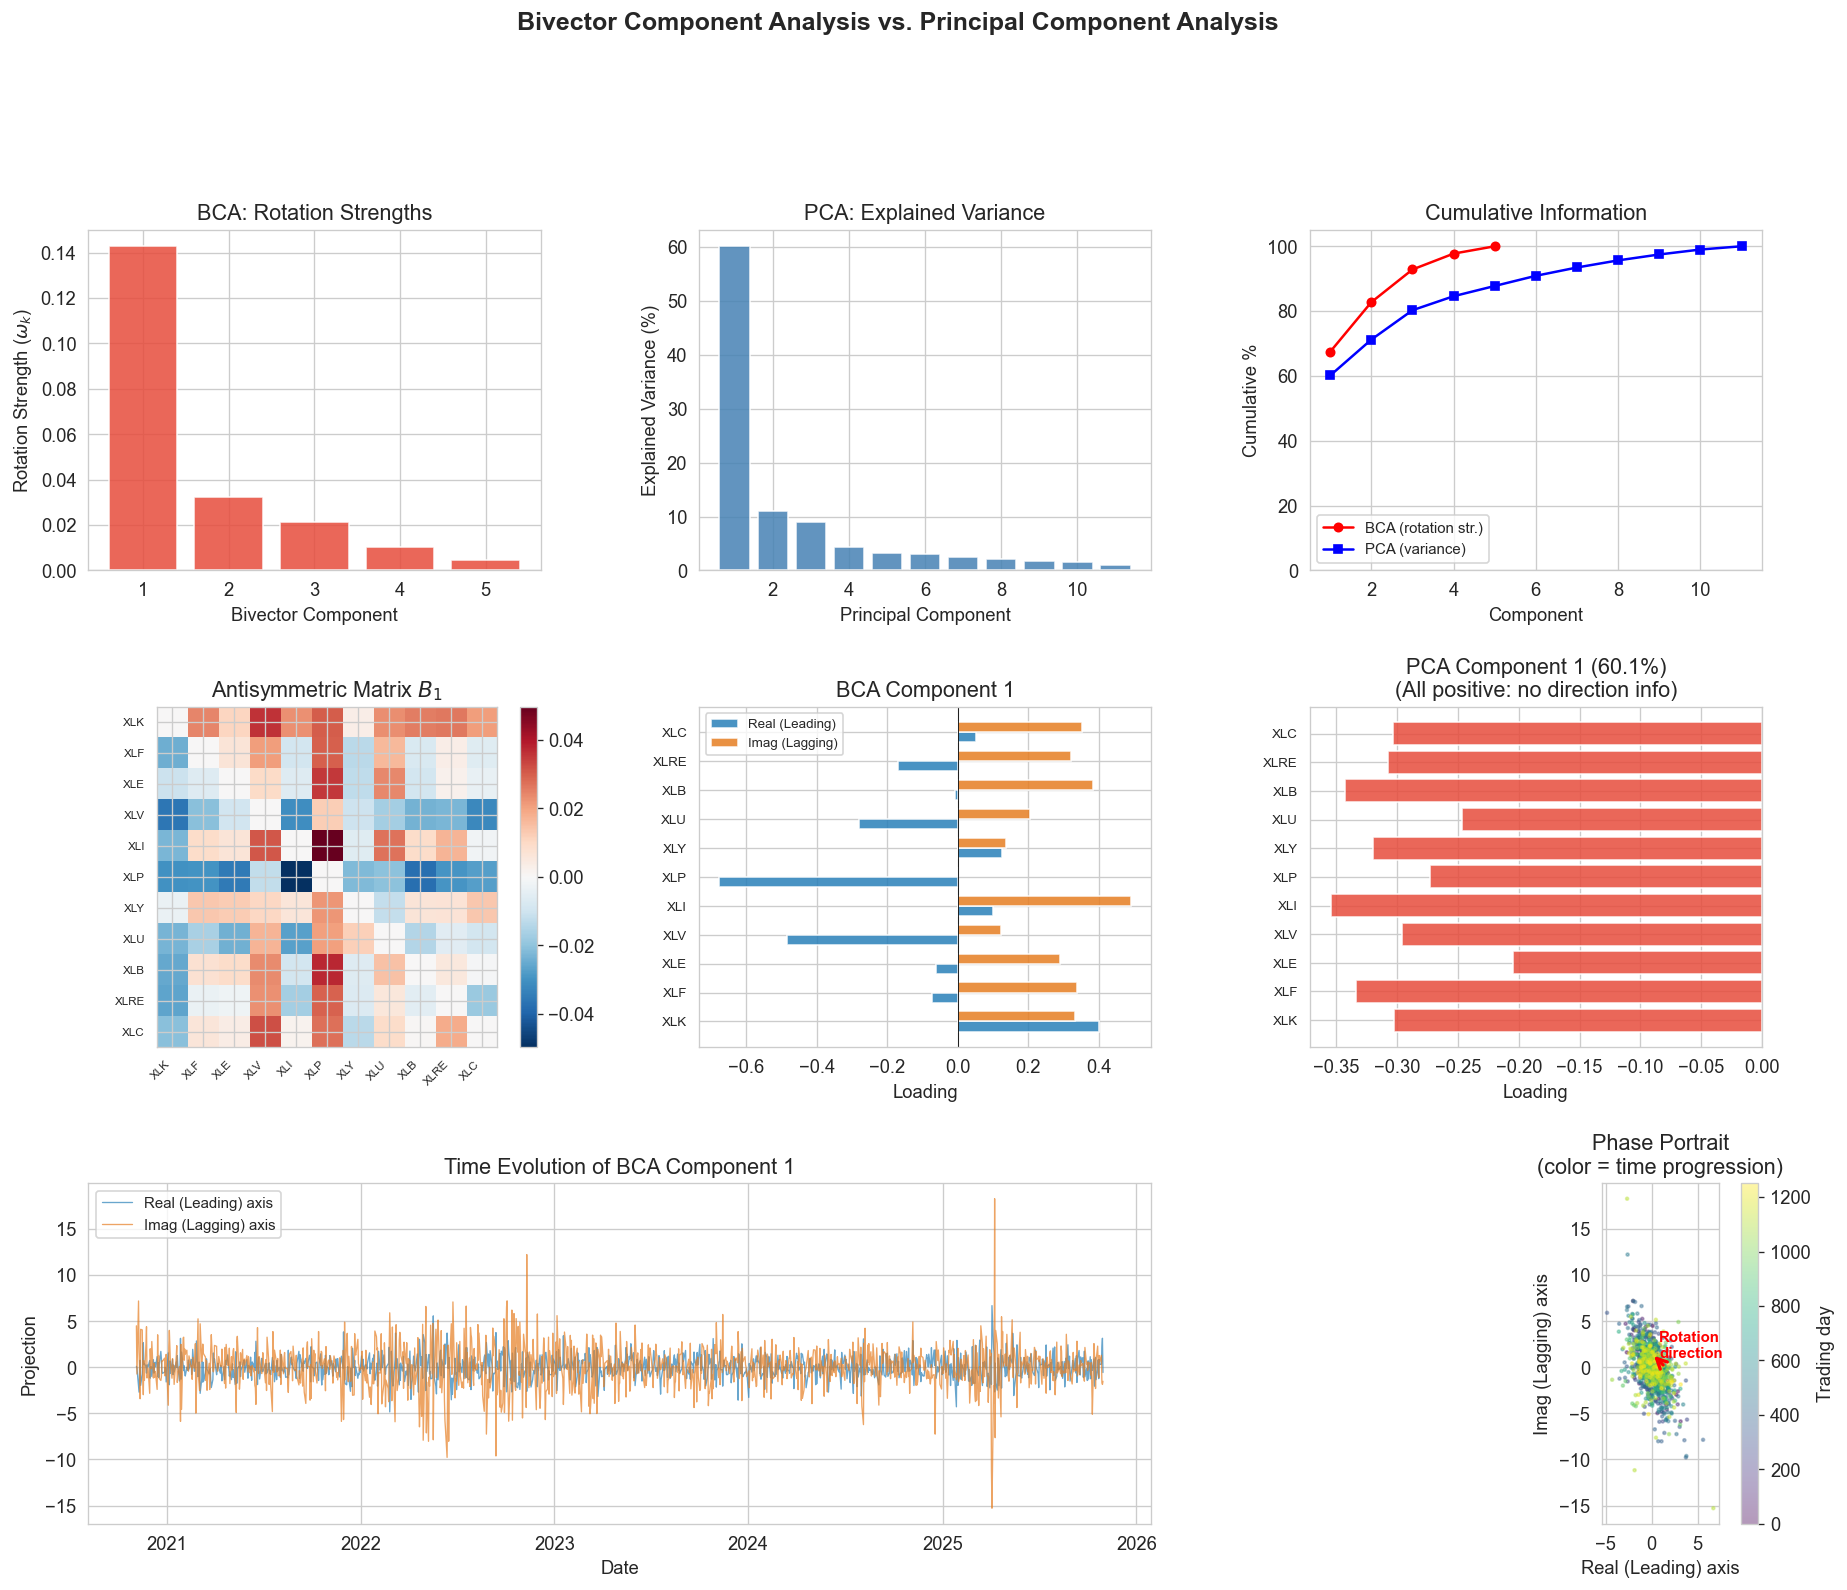

In [31]:
# --- Figure 2: Comprehensive BCA vs PCA Comparison ---
fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.35)

# --- Row 1: Spectrum comparison ---

# (1,1) BCA Rotation Strengths
ax1 = fig.add_subplot(gs[0, 0])
n_bca = len(rotation_strengths)
ax1.bar(range(1, n_bca+1), rotation_strengths, color='#e74c3c', alpha=0.85)
ax1.set_xlabel('Bivector Component')
ax1.set_ylabel('Rotation Strength ($\\omega_k$)')
ax1.set_title('BCA: Rotation Strengths')
ax1.set_xticks(range(1, n_bca+1))

# (1,2) PCA Explained Variance
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(range(1, d+1), explained_var.cpu().numpy(), color='steelblue', alpha=0.85)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance (%)')
ax2.set_title('PCA: Explained Variance')

# (1,3) Cumulative comparison
ax3 = fig.add_subplot(gs[0, 2])
bca_cum = np.cumsum(rotation_strengths) / np.sum(rotation_strengths) * 100
ax3.plot(range(1, n_bca+1), bca_cum, 'ro-', label='BCA (rotation str.)', markersize=5)
ax3.plot(range(1, d+1), cumulative_var.cpu().numpy(), 'bs-', label='PCA (variance)', markersize=5)
ax3.set_xlabel('Component')
ax3.set_ylabel('Cumulative %')
ax3.set_title('Cumulative Information')
ax3.legend(fontsize=9)
ax3.set_ylim([0, 105])

# --- Row 2: Matrix and Loadings ---

# (2,1) Antisymmetric matrix heatmap
ax4 = fig.add_subplot(gs[1, 0])
vmax_B = B_tau.abs().max().item()
im = ax4.imshow(B_tau.cpu().numpy(), cmap='RdBu_r', vmin=-vmax_B, vmax=vmax_B, aspect='equal')
ax4.set_xticks(range(d)); ax4.set_xticklabels(tickers, rotation=45, ha='right', fontsize=7)
ax4.set_yticks(range(d)); ax4.set_yticklabels(tickers, fontsize=7)
ax4.set_title('Antisymmetric Matrix $B_1$')
plt.colorbar(im, ax=ax4, fraction=0.046)

# (2,2) BCA Component 1 loadings
ax5 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(d)
width = 0.35
ax5.barh(x_pos - width/2, u1, width, label='Real (Leading)', color='#2980b9', alpha=0.85)
ax5.barh(x_pos + width/2, w1, width, label='Imag (Lagging)', color='#e67e22', alpha=0.85)
ax5.set_yticks(x_pos)
ax5.set_yticklabels(tickers, fontsize=8)
ax5.axvline(x=0, color='black', linewidth=0.5)
ax5.set_xlabel('Loading')
ax5.set_title('BCA Component 1')
ax5.legend(fontsize=8)

# (2,3) PCA Component 1 loadings (for comparison)
ax6 = fig.add_subplot(gs[1, 2])
colors_pca = ['#2ecc71' if v >= 0 else '#e74c3c' for v in pc1]
ax6.barh(range(d), pc1, color=colors_pca, alpha=0.85)
ax6.set_yticks(range(d))
ax6.set_yticklabels(tickers, fontsize=8)
ax6.axvline(x=0, color='black', linewidth=0.5)
ax6.set_xlabel('Loading')
ax6.set_title(f'PCA Component 1 ({explained_var[0].item():.1f}%)\n(All positive: no direction info)')

# --- Row 3: Time evolution and phase portrait ---

# (3,1) Time evolution of BCA projections
ax7 = fig.add_subplot(gs[2, :2])
X_np = returns_std.values
proj_real = X_np @ u1    # projection onto leading direction
proj_imag = X_np @ w1    # projection onto lagging direction
dates = returns_std.index

ax7.plot(dates, proj_real, label='Real (Leading) axis', alpha=0.7, linewidth=0.8, color='#2980b9')
ax7.plot(dates, proj_imag, label='Imag (Lagging) axis', alpha=0.7, linewidth=0.8, color='#e67e22')
ax7.set_xlabel('Date')
ax7.set_ylabel('Projection')
ax7.set_title('Time Evolution of BCA Component 1')
ax7.legend(fontsize=9)

# (3,3) Phase portrait
ax8 = fig.add_subplot(gs[2, 2])

# Color points by time
time_idx = np.arange(len(proj_real))
norm_time = Normalize(vmin=0, vmax=len(proj_real))
colors_time = cm.viridis(norm_time(time_idx))

scatter = ax8.scatter(proj_real, proj_imag, c=time_idx, cmap='viridis', s=3, alpha=0.4)
ax8.set_xlabel('Real (Leading) axis')
ax8.set_ylabel('Imag (Lagging) axis')
ax8.set_title('Phase Portrait\n(color = time progression)')
ax8.set_aspect('equal')
cbar = plt.colorbar(scatter, ax=ax8, fraction=0.046)
cbar.set_label('Trading day')

# Add rotation arrow
arrow = FancyArrowPatch((1.5, 0), (0, 1.5), 
                        arrowstyle='->', mutation_scale=15, 
                        color='red', linewidth=2)
ax8.add_patch(arrow)
ax8.annotate('Rotation\ndirection', xy=(0.8, 1.0), color='red', fontsize=9, fontweight='bold')

plt.suptitle('Bivector Component Analysis vs. Principal Component Analysis', 
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
fig.savefig('fig_bca_vs_pca.png', dpi=150, bbox_inches='tight')
plt.show()

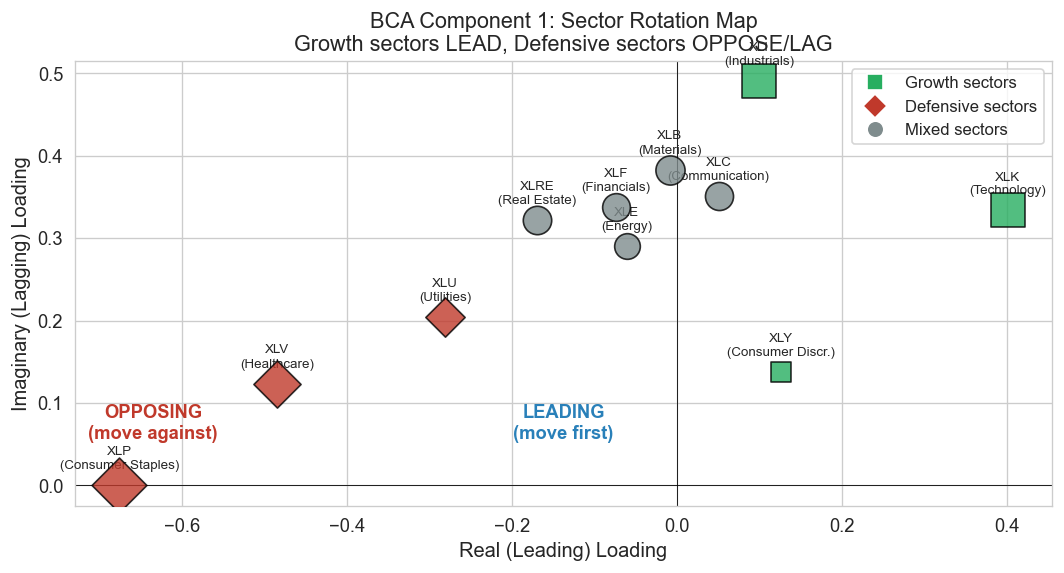

In [32]:
# --- Figure 3: Sector rotation circle ---
fig, ax = plt.subplots(figsize=(9, 9))

# Classify sectors
growth_sectors = {'XLK', 'XLI', 'XLY'}
defensive_sectors = {'XLP', 'XLV', 'XLU'}

for i, ticker in enumerate(tickers):
    if ticker in growth_sectors:
        color = '#27ae60'  # green for growth
        marker = 's'
    elif ticker in defensive_sectors:
        color = '#c0392b'  # red for defensive
        marker = 'D'
    else:
        color = '#7f8c8d'  # gray for mixed
        marker = 'o'
    
    ax.scatter(u1[i], w1[i], s=magnitudes[i]*800, c=color, 
               marker=marker, edgecolors='black', linewidth=1, zorder=5, alpha=0.8)
    ax.annotate(f'{ticker}\n({sector_names[ticker]})', 
                (u1[i], w1[i]), fontsize=8, ha='center', 
                va='bottom' if w1[i] > -0.3 else 'top',
                xytext=(0, 8 if w1[i] > -0.3 else -8), textcoords='offset points')

# Reference lines
ax.axhline(y=0, color='black', linewidth=0.5, linestyle='-')
ax.axvline(x=0, color='black', linewidth=0.5, linestyle='-')

# Quadrant labels
ax.text(0.5, 0.15, 'LEADING\n(move first)', fontsize=11, ha='center', 
        color='#2980b9', fontweight='bold', transform=ax.transAxes)
ax.text(0.08, 0.15, 'OPPOSING\n(move against)', fontsize=11, ha='center', 
        color='#c0392b', fontweight='bold', transform=ax.transAxes)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#27ae60', 
           markersize=10, label='Growth sectors'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='#c0392b', 
           markersize=10, label='Defensive sectors'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#7f8c8d', 
           markersize=10, label='Mixed sectors'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

ax.set_xlabel('Real (Leading) Loading', fontsize=12)
ax.set_ylabel('Imaginary (Lagging) Loading', fontsize=12)
ax.set_title('BCA Component 1: Sector Rotation Map\n'
             'Growth sectors LEAD, Defensive sectors OPPOSE/LAG', fontsize=13)
ax.set_aspect('equal')
plt.tight_layout()
fig.savefig('fig_sector_rotation.png', dpi=150, bbox_inches='tight')
plt.show()

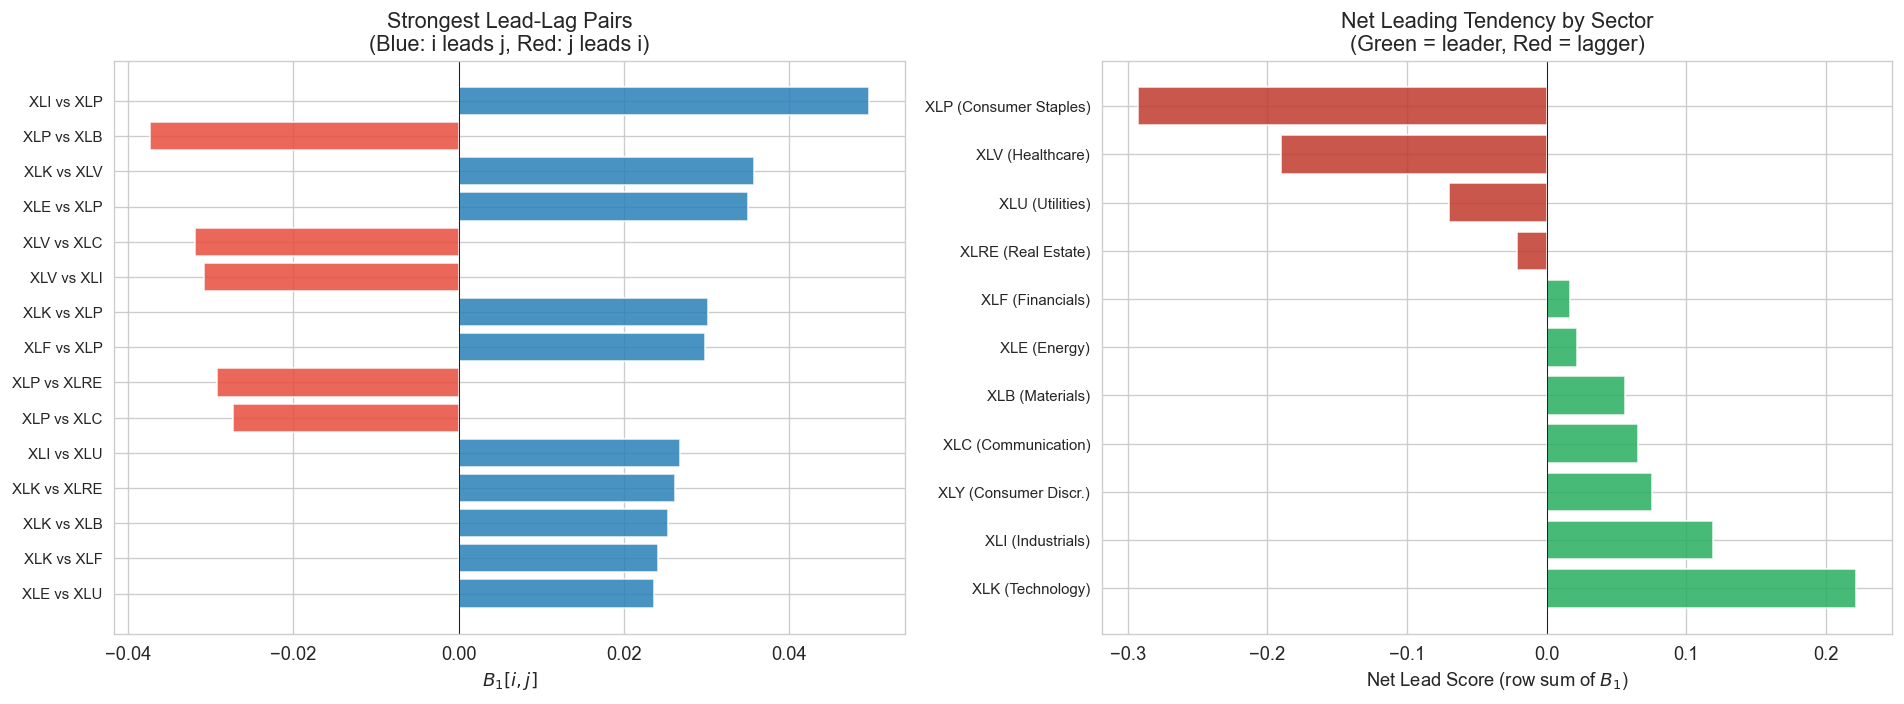

In [33]:
# --- Figure 4: Lead-lag network from antisymmetric matrix ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (Left) Strongest lead-lag pairs
B_np = B_tau.cpu().numpy()
pairs = []
for i in range(d):
    for j in range(i+1, d):
        pairs.append((tickers[i], tickers[j], B_np[i, j]))
pairs_df = pd.DataFrame(pairs, columns=['Asset_i', 'Asset_j', 'B_ij'])
pairs_df['|B_ij|'] = pairs_df['B_ij'].abs()
pairs_df['Direction'] = pairs_df['B_ij'].apply(
    lambda x: f'i leads j' if x > 0 else 'j leads i')
pairs_df = pairs_df.sort_values('|B_ij|', ascending=False)

top_n = 15
top_pairs = pairs_df.head(top_n)
labels_pairs = [f"{r['Asset_i']} vs {r['Asset_j']}" for _, r in top_pairs.iterrows()]
colors_pairs = ['#2980b9' if v > 0 else '#e74c3c' for v in top_pairs['B_ij']]

axes[0].barh(range(top_n), top_pairs['B_ij'].values, color=colors_pairs, alpha=0.85)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(labels_pairs, fontsize=9)
axes[0].axvline(x=0, color='black', linewidth=0.5)
axes[0].set_xlabel('$B_1[i,j]$')
axes[0].set_title('Strongest Lead-Lag Pairs\n(Blue: i leads j, Red: j leads i)')
axes[0].invert_yaxis()

# (Right) Net lead score for each sector
net_lead = B_np.sum(axis=1)  # sum of row = net leading tendency
sort_idx_lead = np.argsort(net_lead)[::-1]
sorted_tickers_lead = [tickers[i] for i in sort_idx_lead]
sorted_labels_lead = [f'{tickers[i]} ({sector_names[tickers[i]]})' for i in sort_idx_lead]
colors_lead = ['#27ae60' if v > 0 else '#c0392b' for v in net_lead[sort_idx_lead]]

axes[1].barh(range(d), net_lead[sort_idx_lead], color=colors_lead, alpha=0.85)
axes[1].set_yticks(range(d))
axes[1].set_yticklabels(sorted_labels_lead, fontsize=9)
axes[1].axvline(x=0, color='black', linewidth=0.5)
axes[1].set_xlabel('Net Lead Score (row sum of $B_1$)')
axes[1].set_title('Net Leading Tendency by Sector\n(Green = leader, Red = lagger)')

plt.tight_layout()
fig.savefig('fig_lead_lag.png', dpi=150, bbox_inches='tight')
plt.show()

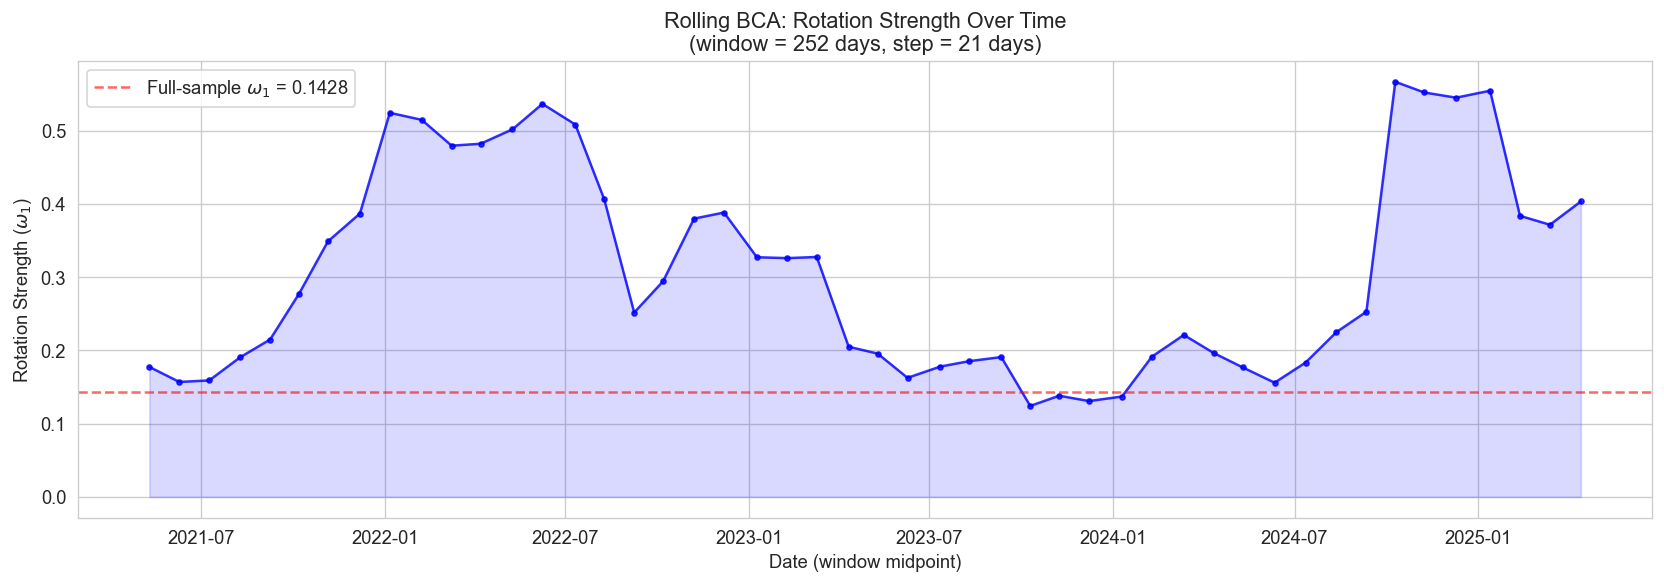

The rolling analysis shows how the strength of sector rotation varies over time.
Peaks may correspond to periods of heightened risk-on/risk-off dynamics.


In [34]:
# --- Figure 5: Rolling BCA analysis ---
# Show how rotation strength evolves over time

window_size = 252  # ~1 year
step_size = 21     # ~1 month

rolling_dates = []
rolling_omega1 = []

for start in range(0, len(returns_std) - window_size, step_size):
    end = start + window_size
    X_window = torch.tensor(returns_std.values[start:end], dtype=torch.float64, device=device)
    
    X_t_w = X_window[:-tau]
    X_t1_w = X_window[tau:]
    n_w = X_t_w.shape[0]
    
    M_w = (X_t_w.T @ X_t1_w) / n_w
    B_w = 0.5 * (M_w - M_w.T)
    
    omega_w, _, _ = bca_decomposition(B_w, n_components=1)
    
    mid_date = returns_std.index[start + window_size // 2]
    rolling_dates.append(mid_date)
    rolling_omega1.append(omega_w[0] if len(omega_w) > 0 else 0)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(rolling_dates, rolling_omega1, 'b-o', markersize=3, linewidth=1.5, alpha=0.8)
ax.fill_between(rolling_dates, 0, rolling_omega1, alpha=0.15, color='blue')
ax.set_xlabel('Date (window midpoint)')
ax.set_ylabel('Rotation Strength ($\\omega_1$)')
ax.set_title(f'Rolling BCA: Rotation Strength Over Time\n(window = {window_size} days, step = {step_size} days)')
ax.axhline(y=rotation_strengths[0], color='red', linestyle='--', alpha=0.6, 
           label=f'Full-sample $\\omega_1$ = {rotation_strengths[0]:.4f}')
ax.legend()
plt.tight_layout()
fig.savefig('fig_rolling_bca.png', dpi=150, bbox_inches='tight')
plt.show()

print('The rolling analysis shows how the strength of sector rotation varies over time.')
print('Peaks may correspond to periods of heightened risk-on/risk-off dynamics.')

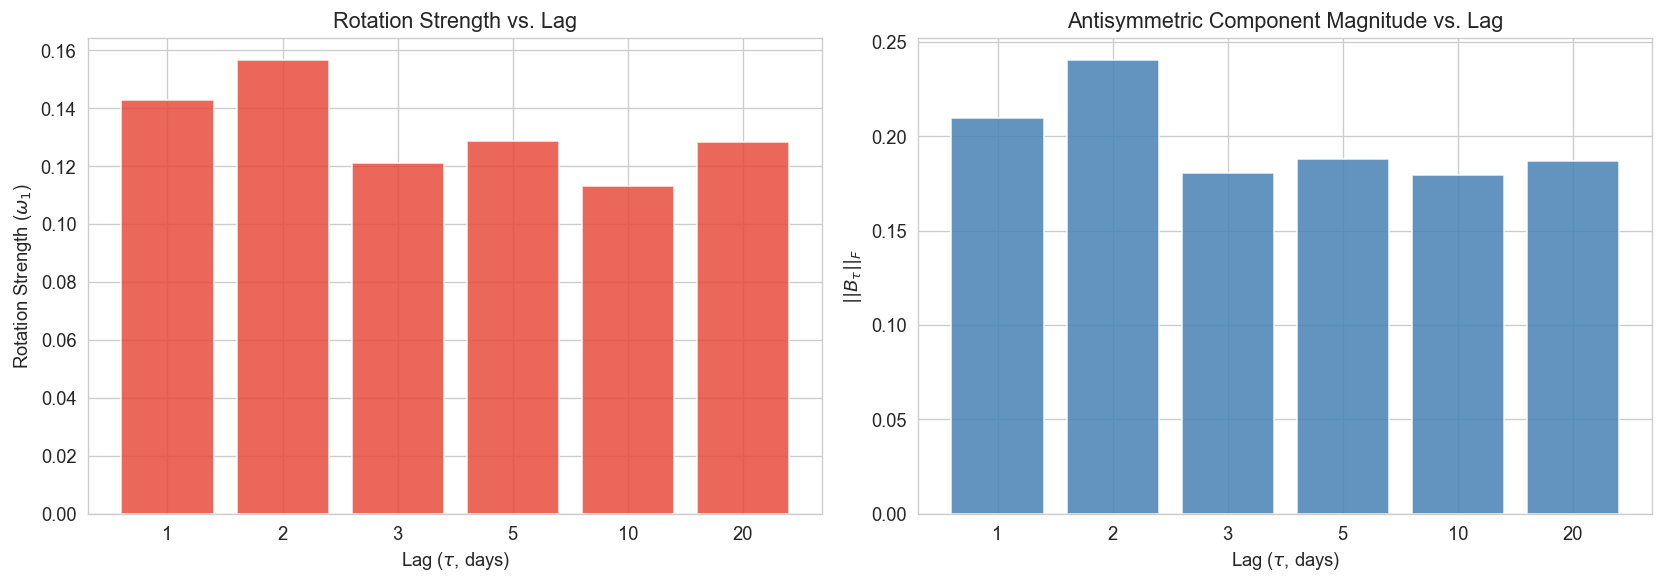


Multi-lag rotation strengths:
  tau= 1 days: omega_1 = 0.1428, ||B||_F = 0.2098
  tau= 2 days: omega_1 = 0.1565, ||B||_F = 0.2402
  tau= 3 days: omega_1 = 0.1212, ||B||_F = 0.1804
  tau= 5 days: omega_1 = 0.1286, ||B||_F = 0.1882
  tau=10 days: omega_1 = 0.1132, ||B||_F = 0.1797
  tau=20 days: omega_1 = 0.1285, ||B||_F = 0.1869


In [35]:
# --- Figure 6: Multi-lag analysis ---
lags = [1, 2, 3, 5, 10, 20]
lag_results = {}

for tau_i in lags:
    X_t_i = X[:-tau_i]
    X_t1_i = X[tau_i:]
    n_i = X_t_i.shape[0]
    
    M_i = (X_t_i.T @ X_t1_i) / n_i
    B_i = 0.5 * (M_i - M_i.T)
    
    omega_i, u_i, w_i = bca_decomposition(B_i, n_components=1)
    lag_results[tau_i] = {
        'omega': omega_i[0] if len(omega_i) > 0 else 0,
        'u': u_i[0] if len(u_i) > 0 else np.zeros(d),
        'w': w_i[0] if len(w_i) > 0 else np.zeros(d),
        'B_fro': torch.norm(B_i, 'fro').item()
    }

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rotation strength vs lag
omegas = [lag_results[t]['omega'] for t in lags]
axes[0].bar(range(len(lags)), omegas, color='#e74c3c', alpha=0.85,
            tick_label=[str(t) for t in lags])
axes[0].set_xlabel('Lag ($\\tau$, days)')
axes[0].set_ylabel('Rotation Strength ($\\omega_1$)')
axes[0].set_title('Rotation Strength vs. Lag')

# Frobenius norm of B vs lag
fros = [lag_results[t]['B_fro'] for t in lags]
axes[1].bar(range(len(lags)), fros, color='steelblue', alpha=0.85,
            tick_label=[str(t) for t in lags])
axes[1].set_xlabel('Lag ($\\tau$, days)')
axes[1].set_ylabel('$||B_\\tau||_F$')
axes[1].set_title('Antisymmetric Component Magnitude vs. Lag')

plt.tight_layout()
fig.savefig('fig_multi_lag.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nMulti-lag rotation strengths:')
for t in lags:
    print(f'  tau={t:2d} days: omega_1 = {lag_results[t]["omega"]:.4f}, ||B||_F = {lag_results[t]["B_fro"]:.4f}')

## 7. Summary and Interpretation

### What BCA Reveals That PCA Cannot

| Aspect | PCA | BCA |
|--------|-----|-----|
| Analyzes | Symmetric covariance $C_\tau$ | Antisymmetric component $B_\tau$ |
| Information | **Co-movement** (which assets move together) | **Lead-lag** (which assets move first) |
| Time direction | Agnostic (same forward/backward) | Sensitive (changes sign under reversal) |
| Eigenvalues | Real, non-negative | Purely imaginary, conjugate pairs |
| Components | Principal axes | Rotation planes (bivectors) |

### Key Findings from Sector ETF Analysis

1. **Growth sectors lead**: Technology (XLK), Industrials (XLI), and Consumer Discretionary (XLY) have positive real (leading) loadings.

2. **Defensive sectors lag/oppose**: Consumer Staples (XLP), Healthcare (XLV), and Utilities (XLU) have strongly negative real loadings, indicating they move in opposition to the leading direction with a lag.

3. **Risk-on/risk-off rotation**: This pattern captures the classic sector rotation where growth sectors move first in risk-on environments, and defensive sectors respond with a delay.

4. **Invisible to PCA**: PCA's first component shows all-positive loadings (market factor) and gives no indication of temporal ordering.

### The Geometric Algebra Perspective

In geometric algebra terms:
- **PCA** captures the *inner product* (scalar/symmetric) part of the lagged geometric product — the magnitude of co-movement.
- **BCA** captures the *outer product* (bivector/antisymmetric) part — the *oriented plane* of rotation in data space.

Together, PCA + BCA provide a complete second-order description of lagged multivariate structure, analogous to how the geometric product $xy = x \cdot y + x \wedge y$ provides a complete algebraic description of the relationship between two vectors.

In [36]:
# Final summary statistics
print('=' * 60)
print('BIVECTOR COMPONENT ANALYSIS — SUMMARY')
print('=' * 60)
print(f'Data: {d} sector ETFs, {T} trading days')
print(f'Lag: tau = {tau} day(s)')
print(f'\nFrobenius decomposition:')
print(f'  ||M_tau||_F = {frob_M:.4f}')
print(f'  ||C_tau||_F = {frob_C:.4f} ({frob_C**2/frob_M**2*100:.1f}% of energy — symmetric/PCA)')
print(f'  ||B_tau||_F = {frob_B:.4f} ({frob_B**2/frob_M**2*100:.1f}% of energy — antisymmetric/BCA)')
print(f'\nTop BCA rotation strengths:')
for k in range(min(3, len(rotation_strengths))):
    print(f'  omega_{k+1} = {rotation_strengths[k]:.4f}')
print(f'\nLeading sectors (positive real loading):')
for i, t in enumerate(tickers):
    if u1[i] > 0.05:
        print(f'  {t} ({sector_names[t]}): u = {u1[i]:+.3f}')
print(f'\nLagging/opposing sectors (negative real loading):')
for i, t in enumerate(tickers):
    if u1[i] < -0.05:
        print(f'  {t} ({sector_names[t]}): u = {u1[i]:+.3f}')

BIVECTOR COMPONENT ANALYSIS — SUMMARY
Data: 11 sector ETFs, 1252 trading days
Lag: tau = 1 day(s)

Frobenius decomposition:
  ||M_tau||_F = 0.2751
  ||C_tau||_F = 0.1779 (41.8% of energy — symmetric/PCA)
  ||B_tau||_F = 0.2098 (58.2% of energy — antisymmetric/BCA)

Top BCA rotation strengths:
  omega_1 = 0.1428
  omega_2 = 0.0324
  omega_3 = 0.0213

Leading sectors (positive real loading):
  XLK (Technology): u = +0.401
  XLI (Industrials): u = +0.100
  XLY (Consumer Discr.): u = +0.126
  XLC (Communication): u = +0.051

Lagging/opposing sectors (negative real loading):
  XLF (Financials): u = -0.074
  XLE (Energy): u = -0.061
  XLV (Healthcare): u = -0.485
  XLP (Consumer Staples): u = -0.677
  XLU (Utilities): u = -0.281
  XLRE (Real Estate): u = -0.170
